In [209]:
%matplotlib inline
from __future__ import division
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import pylab as pl
import numpy as np
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, auc, confusion_matrix, recall_score, precision_score


## Predicting Gender based on 3rd Party Audience Segments that Users are identified with

3rd Party data providers work with publishers to gather touch points by users online. Based on their online bahaviour, cookie IDs are assigned to audience segments. 

In the new advertising world of people based marketing, it is believed that these online touch points can help advertisers improve their targeting. Eg. Instead of targeting all users online with the same creatives, an advertiser can decide to target only Males Segment users that have shown interest in Sports if they believe that these users highly resonate with their brand.

What segments however should the advertiser use to streamline their target? Are the audience segments able to clearly segment out high potential converters for an ecommerce client?.

For a start, I will be using the audience segments to predict the gender of a cookie ID (instead of predicting if will be converters for an advertiser).

### Read File

In [210]:
ccs_sg = pd.read_csv("C:\\Users\\YCHEN06\\Desktop\\data\\ccs_audiences.csv", )

In [211]:
ccs_gender = pd.read_csv("C:\\Users\\YCHEN06\\Desktop\\data\\ccs_gender.csv", )

### Explore data

In [4]:
ccs_sg.head()

,mm_uuid,provider,segment id,full path,date
0,033f545c-6429-4000-a828-47695b9e2c52,ey,18511,|Eyeota|Branded Data|Global excluding US and E...,5/7/2017
1,033f545c-6429-4000-a828-47695b9e2c52,ey,18284,|Eyeota|Branded Data|Global excluding US and E...,5/7/2017
2,033f545c-6429-4000-a828-47695b9e2c52,ey,18182,|Eyeota|Branded Data|Global excluding US and E...,5/7/2017
3,033f545c-6429-4000-a828-47695b9e2c52,ey,405,|Eyeota|Interest|Entertainment|News,5/7/2017
4,033f545c-6429-4000-a828-47695b9e2c52,ey,17580,|Eyeota|Branded Data|Global excluding US and E...,5/7/2017


Variable | Description | Type of Variable
---| ---| ---
mm-uuid | distinct online user ID (by cookie ID)  | categorical
provider | source of data | categorical
segment id | unique identifier for full path| categorical
full path | audience segment that user is identified in by provider | descriptive
date | daatestamp of when user was added to the segment | date

In [5]:
ccs_sg.count()

mm_uuid       17253
provider      17253
segment id    17253
full path     17253
date          17253
dtype: int64

In [6]:
ccs_gender.head()

,aac_uuid,ccs_uid,Gender
0,e09d5775-1aa2-4f00-af1b-3b0383b6a6e7,SGP16200003077,Female
1,bfa45769-3bcd-4000-96c8-e32efea73c5c,SGP16200003092,Male
2,ef5b573b-e9b6-4400-a9ab-ec12a0da6d25,SGP16200003071,Male
3,e15c55b4-98f3-4600-866d-496c962744bb,SGP16200003046,Female
4,7a175753-c3b9-4d00-a599-059eb41a860f,SGP16200003065,Female


Variable | Description | Type of Variable
---| ---| ---
aac_uuid | equivalue of mm_uuid  | categorical
ccs_uid | distinct offline user id | categorical
Gender | Female of Male (Declared Data)| categorical

In [7]:
ccs_gender.count()

aac_uuid    1613
ccs_uid     1613
Gender      1613
dtype: int64

### Count of Attributes by Users

#### All

In [8]:
mm_uuid_cnt = ccs_sg.mm_uuid.value_counts()

In [9]:
mm_uuid_cnt.head()

a97d5693-216d-4500-b6de-568a2e87dfd9    649
b55a569f-9000-4d00-a977-98afb2d65b9f    603
9a60557c-f1a2-4b00-b39a-2842a4df66b2    513
033f545c-6429-4000-a828-47695b9e2c52    497
80be54c4-59f9-4900-82de-1f220b31740d    430
Name: mm_uuid, dtype: int64

In [10]:
mm_uuid_cnt.count()

148

## 148 ccs users were found with at least 1 audience segment attribute.

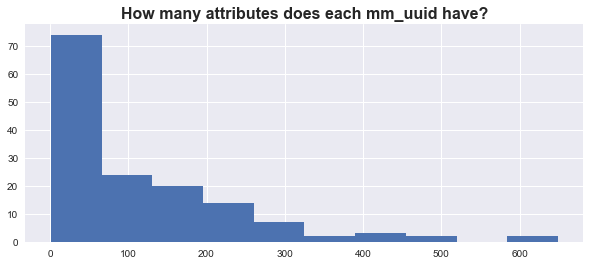

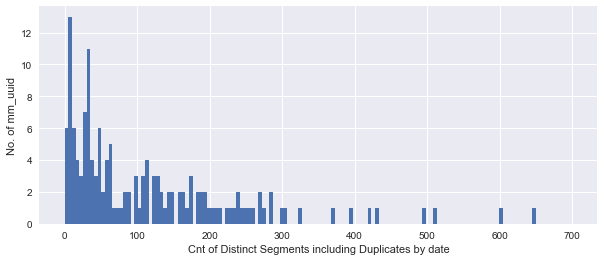

In [11]:
binBoundaries = np.linspace(0,700,140)

plt.title('How many attributes does each mm_uuid have?', fontsize=16, fontweight='bold')
mm_uuid_cnt.hist(figsize=(10,4))

fig = plt.figure()
mm_uuid_cnt.hist(figsize=(10,4), bins=binBoundaries)

plt.xlabel('Cnt of Distinct Segments including Duplicates by date')
plt.ylabel('No. of mm_uuid')


#### Dedup Repeated Segments

Segments for each mm_uuid is associated with a datestamp. Some users may get assigned to the same segment again across time. To count each segment once only for each user, the data set needs to be deduplicated.

In [212]:
unique_segments_mmuuid = ccs_sg.drop_duplicates(['mm_uuid','segment id','full path'])

In [213]:
unique_segments_mmuuid_summarize = unique_segments_mmuuid['mm_uuid'].value_counts()

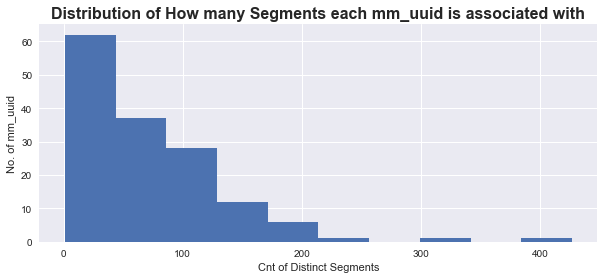

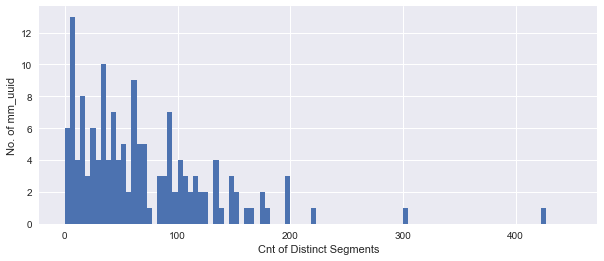

In [214]:
binBoundaries = np.linspace(0,450,100)

fig = plt.figure()
plt.title('Distribution of How many Segments each mm_uuid is associated with', fontsize=16, fontweight='bold')
unique_segments_mmuuid_summarize.hist(figsize=(10,4))
plt.xlabel('Cnt of Distinct Segments')
plt.ylabel('No. of mm_uuid')

fig = plt.figure()
unique_segments_mmuuid_summarize.hist(figsize=(10,4),bins=binBoundaries)
plt.xlabel('Cnt of Distinct Segments')
plt.ylabel('No. of mm_uuid')

### Most Popular Segments

#### All 

In [215]:
segment_cnt = ccs_sg['full path'].value_counts()

In [216]:
segment_cnt.count()

899

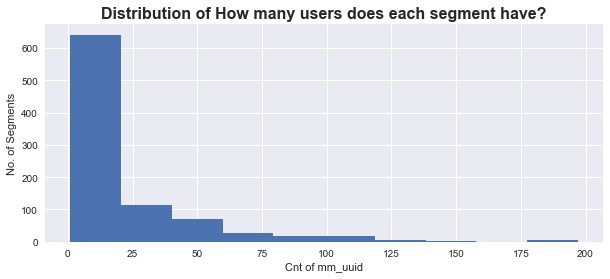

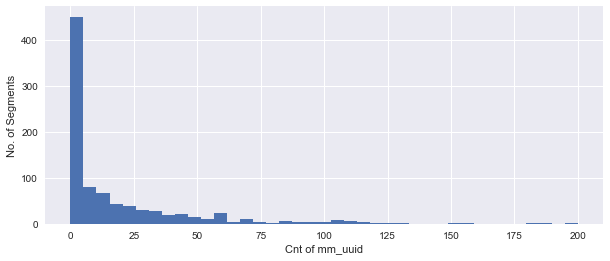

In [217]:
binBoundaries = np.linspace(0,200,40)

fig = plt.figure()
segment_cnt.hist(figsize=(10,4))
plt.title('Distribution of How many users does each segment have?', fontsize=16, fontweight='bold')
plt.xlabel('Cnt of mm_uuid')
plt.ylabel('No. of Segments')

fig = plt.figure()
segment_cnt.hist(figsize=(10,4),bins=binBoundaries)
plt.xlabel('Cnt of mm_uuid')
plt.ylabel('No. of Segments')

In [18]:
segment_cnt.head(20)

|Eyeota|Business or B2B                                                                                     197
|Eyeota|Regional Taxonomies|Southeast Asia (SEA)|Interest|Tech Enthusiasts                                  189
|Eyeota|Branded Data|Global Bombora|B2B|Professional Groups|Business Professional                           187
|Eyeota|Business or B2B|Professions|Business Professionals                                                  184
|Eyeota|Interest|Tech Enthusiasts                                                                           182
|Eyeota|Business or B2B|Interest|Marketing and Advertising                                                  157
|Eyeota|Regional Taxonomies|Southeast Asia (SEA)|Interest|Arts and Entertainment                            154
|Eyeota|Interest|Entertainment                                                                              152
|Eyeota|Demographic|Employment Industry|HR and Recruitment                                              

#### Dedup Repeated Segments

We deduplicated repeated segments mm_uuids have a date stamp association. This means that day after day, the users is getting placed back in the same segment again

In [19]:
unique_segments_mmuuid_summarizesegment = unique_segments_mmuuid['full path'].value_counts()

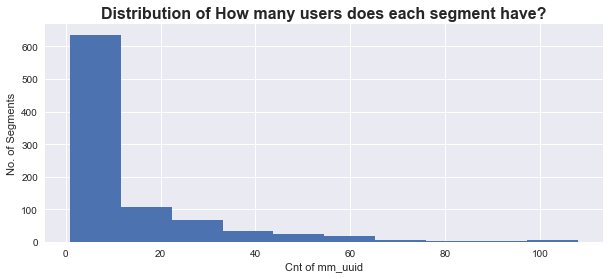

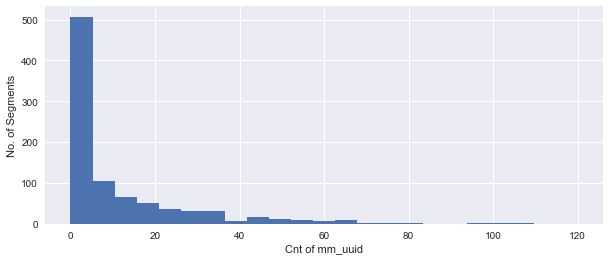

In [20]:
binBoundaries = np.linspace(0,120,24)

fig = plt.figure()
unique_segments_mmuuid_summarizesegment.hist(figsize=(10,4))
plt.title('Distribution of How many users does each segment have?', fontsize=16, fontweight='bold')
plt.xlabel('Cnt of mm_uuid')
plt.ylabel('No. of Segments')

fig = plt.figure()
unique_segments_mmuuid_summarizesegment.hist(figsize=(10,4),bins=binBoundaries)
plt.xlabel('Cnt of mm_uuid')
plt.ylabel('No. of Segments')

In [21]:
unique_segments_mmuuid_summarizesegment.head()

|Eyeota|Business or B2B                                                              108
|Eyeota|Branded Data|Global Bombora|B2B|Professional Groups|Business Professional    102
|Eyeota|Interest|Tech Enthusiasts                                                    101
|Eyeota|Business or B2B|Professions|Business Professionals                           100
|Eyeota|Regional Taxonomies|Southeast Asia (SEA)|Interest|Tech Enthusiasts            97
Name: full path, dtype: int64

#### Finding Commonly repeated Segments

In [218]:
segment_mm_uuid_cnt = ccs_sg[['mm_uuid','full path']].groupby(['full path']).nunique()

In [219]:
ccs_sg['combined'] = ccs_sg.mm_uuid + ccs_sg.date

In [220]:
segment_combined_cnt = ccs_sg[['combined','full path']].groupby(['full path']).nunique()

In [221]:
segment = pd.concat([segment_mm_uuid_cnt,segment_combined_cnt],axis=1,join='inner')

In [222]:
segment['freq']=segment['combined']/segment['mm_uuid']

In [223]:
segment[segment['mm_uuid']>10].sort_values(['freq'],ascending=False).head(10)

,mm_uuid,full path,combined,full path,freq
full path,,,,,
|Eyeota|Regional Taxonomies|Southeast Asia (SEA)|Interest|Pets,15,1,37,1,2.466667
|Eyeota|Intent|Financial Intent|Personal Finance,17,1,40,1,2.352941
|Eyeota|Demographic|Inferred Age|21-24,17,1,38,1,2.235294
|Eyeota|Demographic|Lifestyle|Household Decision Makers,21,1,44,1,2.095238
|Eyeota|Regional Taxonomies|Southeast Asia (SEA)|Interest|Fashion and Beauty,11,1,23,1,2.090909
|Eyeota|Interest|Parenting,11,1,23,1,2.090909
|Eyeota|Branded Data|Global Bombora|B2C|Lifestyle|Hobbies and Interests|Gardening,11,1,23,1,2.090909
|Eyeota|Branded Data|Global Bombora|B2B|B2B Predictive Signals|Human Resources|Performance,12,1,25,1,2.083333
|Eyeota|Demographic|Inferred Age|25-34,30,1,62,1,2.066667


### Creating Dummy Variables for Audence Segment

In [224]:
create_dummies_data = ccs_sg[['mm_uuid','full path']].drop_duplicates(['mm_uuid','full path'])

In [225]:
create_dummies_data.count()

mm_uuid      10273
full path    10273
dtype: int64

In [226]:
create_dummies_data.head()

,mm_uuid,full path
0,033f545c-6429-4000-a828-47695b9e2c52,|Eyeota|Branded Data|Global excluding US and E...
1,033f545c-6429-4000-a828-47695b9e2c52,|Eyeota|Branded Data|Global excluding US and E...
2,033f545c-6429-4000-a828-47695b9e2c52,|Eyeota|Branded Data|Global excluding US and E...
3,033f545c-6429-4000-a828-47695b9e2c52,|Eyeota|Interest|Entertainment|News
4,033f545c-6429-4000-a828-47695b9e2c52,|Eyeota|Branded Data|Global excluding US and E...


In [227]:
dummies = pd.get_dummies(create_dummies_data['full path']).join(create_dummies_data['mm_uuid'])

In [228]:
cols = dummies.columns[1:]

In [229]:
dummies = dummies.groupby(['mm_uuid'])[cols].sum()

In [230]:
dummies['segment_cnt']=dummies.sum(axis=1)

In [231]:
dummies.head()

,|Eyeota|Branded Data|EMEA|EMEA ShareThis|Arts and Entertainment|Humor,|Eyeota|Branded Data|EMEA|EMEA ShareThis|Computers and Electronics,|Eyeota|Branded Data|EMEA|EMEA ShareThis|Computers and Electronics|Software,|Eyeota|Branded Data|EMEA|EMEA ShareThis|Computers and Electronics|Software|Open Source,|Eyeota|Branded Data|EMEA|EMEA ShareThis|Food and Drink|Food|Meat and Seafood,|Eyeota|Branded Data|EMEA|EMEA ShareThis|Home and Garden,|Eyeota|Branded Data|EMEA|EMEA ShareThis|Home and Garden|Bed and Bath,|Eyeota|Branded Data|EMEA|EMEA ShareThis|Home and Garden|Bed and Bath|Bathroom,|Eyeota|Branded Data|EMEA|EMEA ShareThis|Internet and Telecom,|Eyeota|Branded Data|EMEA|EMEA ShareThis|Internet and Telecom|Service Providers,...,|Eyeota|Seasonal|Sport Events|Football Matches|Champions League Fans,|Eyeota|Seasonal|Sport Events|Football Matches|EURO 2016 France,|Eyeota|Seasonal|Sport Events|Football Matches|EURO 2016 France|Qualifiers,|Eyeota|Seasonal|Sport Events|Football Matches|FIFA World Cup 2018,|Eyeota|Seasonal|Sport Events|NBA,|Eyeota|Seasonal|Sport Events|Premier League Fans,|Eyeota|Seasonal|Sport Events|Rugby World Cup Fans,|Eyeota|Seasonal|Sport Events|Summer Olympics - Rio 2016,|Eyeota|Seasonal|Sport Events|Winter Olympics - Pyeongchang 2018,segment_cnt
mm_uuid,,,,,,,,,,,,,,,,,,,,,
033f545c-6429-4000-a828-47695b9e2c52,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,198
035c551c-097e-4900-80c9-f9df6a50452c,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,63
04f155da-cfb4-4000-9cb9-f22a71107b06,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,70
07d955de-7752-4d00-8d65-a4f5d07ee390,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,58
08ed55cd-4a26-4a00-9750-8f3d8413d258,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,65


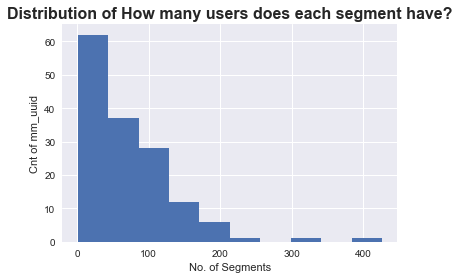

In [232]:
fig = plt.figure()
dummies['segment_cnt'].hist()
plt.title('Distribution of How many users does each segment have?', fontsize=16, fontweight='bold')
plt.xlabel('No. of Segments')
plt.ylabel('Cnt of mm_uuid')

In [233]:
dummies.sort_values(['segment_cnt'],ascending=False)

,|Eyeota|Branded Data|EMEA|EMEA ShareThis|Arts and Entertainment|Humor,|Eyeota|Branded Data|EMEA|EMEA ShareThis|Computers and Electronics,|Eyeota|Branded Data|EMEA|EMEA ShareThis|Computers and Electronics|Software,|Eyeota|Branded Data|EMEA|EMEA ShareThis|Computers and Electronics|Software|Open Source,|Eyeota|Branded Data|EMEA|EMEA ShareThis|Food and Drink|Food|Meat and Seafood,|Eyeota|Branded Data|EMEA|EMEA ShareThis|Home and Garden,|Eyeota|Branded Data|EMEA|EMEA ShareThis|Home and Garden|Bed and Bath,|Eyeota|Branded Data|EMEA|EMEA ShareThis|Home and Garden|Bed and Bath|Bathroom,|Eyeota|Branded Data|EMEA|EMEA ShareThis|Internet and Telecom,|Eyeota|Branded Data|EMEA|EMEA ShareThis|Internet and Telecom|Service Providers,...,|Eyeota|Seasonal|Sport Events|Football Matches|Champions League Fans,|Eyeota|Seasonal|Sport Events|Football Matches|EURO 2016 France,|Eyeota|Seasonal|Sport Events|Football Matches|EURO 2016 France|Qualifiers,|Eyeota|Seasonal|Sport Events|Football Matches|FIFA World Cup 2018,|Eyeota|Seasonal|Sport Events|NBA,|Eyeota|Seasonal|Sport Events|Premier League Fans,|Eyeota|Seasonal|Sport Events|Rugby World Cup Fans,|Eyeota|Seasonal|Sport Events|Summer Olympics - Rio 2016,|Eyeota|Seasonal|Sport Events|Winter Olympics - Pyeongchang 2018,segment_cnt
mm_uuid,,,,,,,,,,,,,,,,,,,,,
9a60557c-f1a2-4b00-b39a-2842a4df66b2,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,426
a97d5693-216d-4500-b6de-568a2e87dfd9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,304
b55a569f-9000-4d00-a977-98afb2d65b9f,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,220
58795583-dd06-4d00-a85c-f7f625e14751,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,200
033f545c-6429-4000-a828-47695b9e2c52,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,198
26c954e1-d9f4-4c00-9c51-ff4a5e95fb8a,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,197
22c4553e-62bc-4800-931a-2bdc199995fc,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,180
80be54c4-59f9-4900-82de-1f220b31740d,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,174
cfa55421-8086-4600-a96b-473cedaf8935,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,173


In [234]:
segment_popularity =pd.DataFrame.from_dict(dummies[dummies.columns[1:]].sum())

In [235]:
segment_popularity.describe()

,0
count,898.000000
mean,22.876392
std,342.802301
min,1.000000
25%,1.000000
50%,4.000000
75%,15.000000
max,10272.000000


In [236]:
segment_popularity.sort_values(0, ascending=False).head(20)

,0
segment_cnt,10272
|Eyeota|Business or B2B,108
|Eyeota|Branded Data|Global Bombora|B2B|Professional Groups|Business Professional,102
|Eyeota|Interest|Tech Enthusiasts,101
|Eyeota|Business or B2B|Professions|Business Professionals,100
|Eyeota|Regional Taxonomies|Southeast Asia (SEA)|Interest|Tech Enthusiasts,97
|Eyeota|Business or B2B|Interest|Marketing and Advertising,81
|Eyeota|Interest|Entertainment,79
|Eyeota|Regional Taxonomies|Southeast Asia (SEA)|Interest|Arts and Entertainment,77
|Eyeota|Business or B2B|Interest|IT and Technology,74


### Merging the Audience Data with Declared Gender

In [237]:
ccs_gender.columns=['mm_uuid', 'ccs_uid', 'Gender']

In [238]:
dummies=dummies.reset_index()

In [239]:
data = ccs_gender.join(dummies.set_index('mm_uuid'),how='right',on='mm_uuid')

In [240]:
data.head()

,mm_uuid,ccs_uid,Gender,|Eyeota|Branded Data|EMEA|EMEA ShareThis|Arts and Entertainment|Humor,|Eyeota|Branded Data|EMEA|EMEA ShareThis|Computers and Electronics,|Eyeota|Branded Data|EMEA|EMEA ShareThis|Computers and Electronics|Software,|Eyeota|Branded Data|EMEA|EMEA ShareThis|Computers and Electronics|Software|Open Source,|Eyeota|Branded Data|EMEA|EMEA ShareThis|Food and Drink|Food|Meat and Seafood,|Eyeota|Branded Data|EMEA|EMEA ShareThis|Home and Garden,|Eyeota|Branded Data|EMEA|EMEA ShareThis|Home and Garden|Bed and Bath,...,|Eyeota|Seasonal|Sport Events|Football Matches|Champions League Fans,|Eyeota|Seasonal|Sport Events|Football Matches|EURO 2016 France,|Eyeota|Seasonal|Sport Events|Football Matches|EURO 2016 France|Qualifiers,|Eyeota|Seasonal|Sport Events|Football Matches|FIFA World Cup 2018,|Eyeota|Seasonal|Sport Events|NBA,|Eyeota|Seasonal|Sport Events|Premier League Fans,|Eyeota|Seasonal|Sport Events|Rugby World Cup Fans,|Eyeota|Seasonal|Sport Events|Summer Olympics - Rio 2016,|Eyeota|Seasonal|Sport Events|Winter Olympics - Pyeongchang 2018,segment_cnt
35,152a56c3-d253-4b00-b7fa-8114c399815b,SGP16200000312,Male,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,146
37,1cf455cf-1993-4000-8175-b128aec36937,SGP16200004196,Female,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,32
53,9c9553b3-b1e2-4400-9d9f-bebfb2b0702a,SGP16200004293,Male,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,66
54,ff7756d5-73d8-4e00-a738-ccdfbed7e3be,SGP16200004356,Male,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,120
76,92c354f6-a838-4f00-9d57-8f9bf22c7990,SGP16200004395,Female,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,32


### Explore Data with Declared Data

In [241]:
pop_segments = segment_popularity.sort_values(0, ascending=False)[1:].head(10).reset_index()
pop_segments.columns = ['segment','cnt']
select = list(pop_segments['segment'])

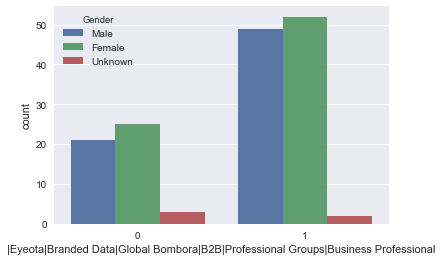

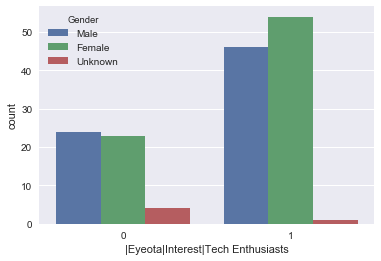

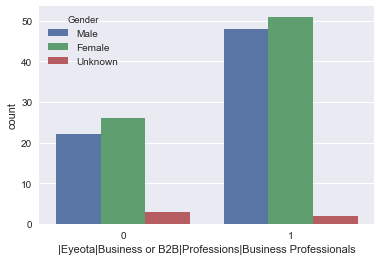

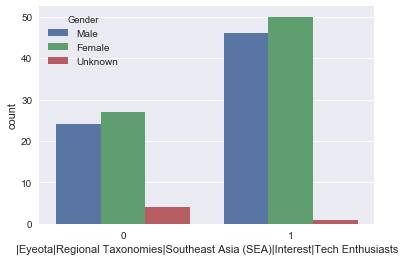

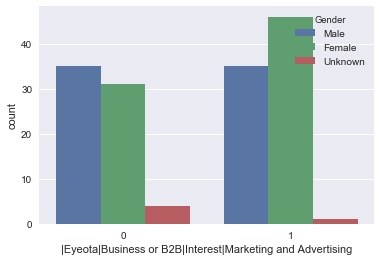

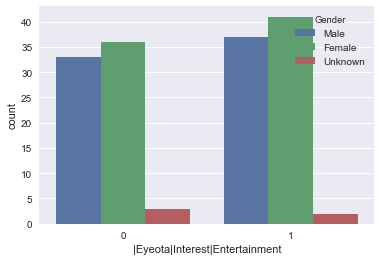

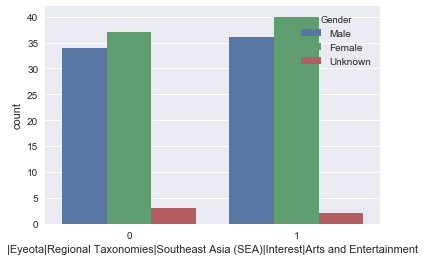

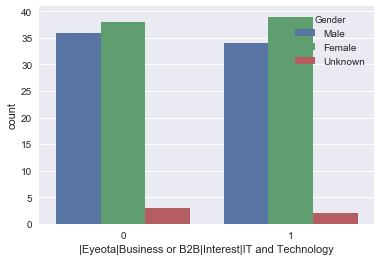

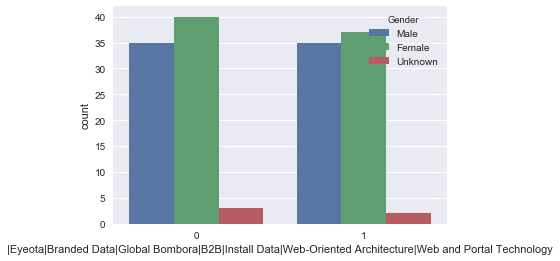

In [242]:
figs = {}
axs={}

for i in range(1,10):    
    figs[i]=plt.figure()
    axs[i] = sns.countplot(x=select[i], hue="Gender", data=data)

In [243]:
def random():
    random_segments = segment_popularity.sample(n=1).reset_index()
    random_segments.columns = ['segment','cnt']
    random = list(random_segments['segment'])
    fig = plt.figure()
    plt.title(random[0], fontsize=16, fontweight='bold')
    sns.countplot(x=random[0], hue="Gender", data=data)

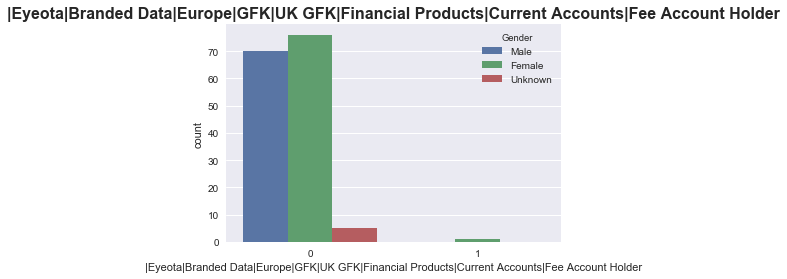

In [244]:
random()

In [49]:
gender_cols = [col for col in data.columns if 'male' in col]+[col for col in data.columns if 'Male' in col]
gender_cols

['|Eyeota|Branded Data|Global Bombora|B2C|Gender|Female',
 '|Eyeota|Branded Data|USA|US StatSocial|Legendary Entertainment|Demographics|Gender|Female',
 '|Eyeota|Demographic|Declared Gender|Female',
 '|Eyeota|Demographic|Inferred Gender|Female',
 '|Eyeota|Regional Taxonomies|Southeast Asia (SEA)|Demographic|Inferred Gender|Female',
 '|Eyeota|Branded Data|Global Bombora|B2C|Gender|Male',
 '|Eyeota|Demographic|Declared Gender|Male',
 '|Eyeota|Demographic|Inferred Gender|Male',
 '|Eyeota|Regional Taxonomies|Southeast Asia (SEA)|Demographic|Inferred Gender|Male']

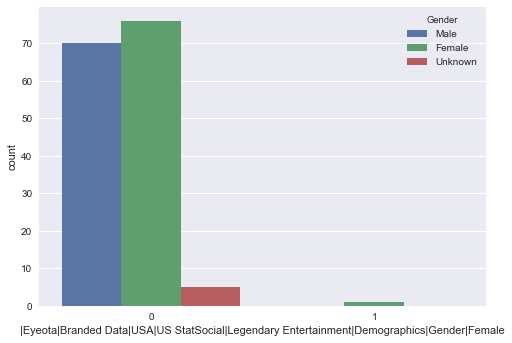

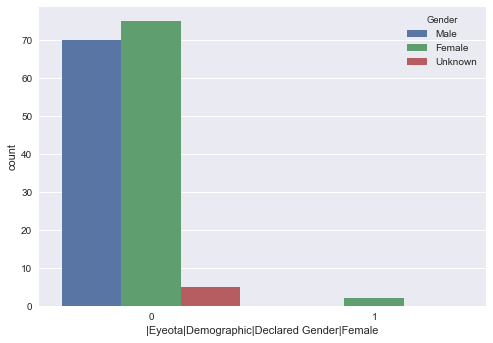

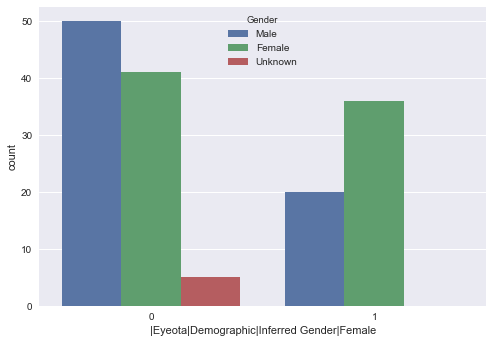

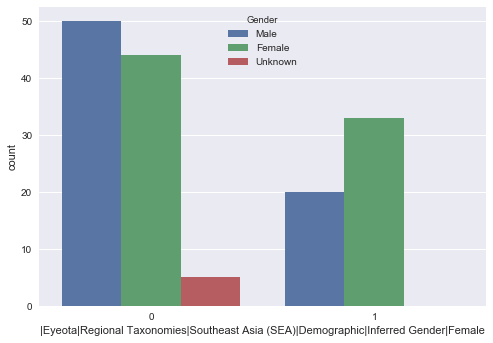

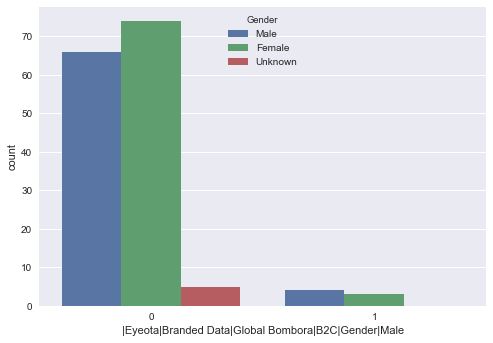

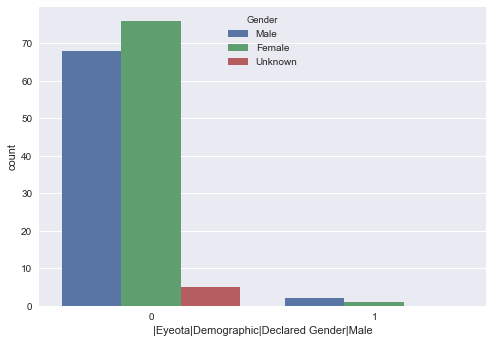

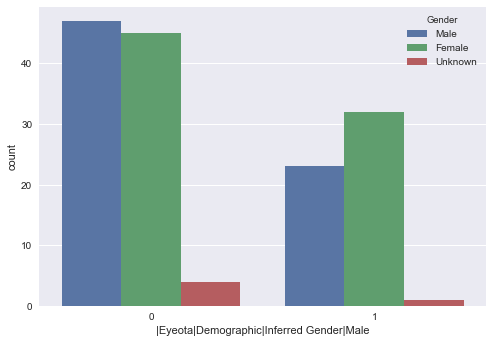

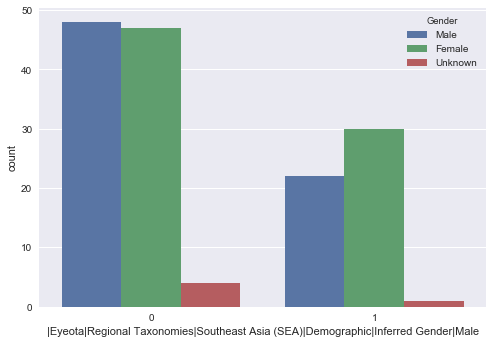

In [50]:
figs = {}
axs={}

for i in range(1,9):    
    figs[i]=plt.figure()
    axs[i] = sns.countplot(x=gender_cols[i], hue="Gender", data=data)

### Creating Models

In [319]:
data=data[data['Gender']!='Unknown']

In [324]:
data['Gender_1_0']=data['Gender']

In [325]:
 d = {'Female': 1, 'Male': 0}

In [326]:
data['Gender_1_0']=data['Gender_1_0'].replace(d)

### Random Forest

#### Single Basic Model

In [327]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators = 20, max_depth=50)
X = data[data.columns[3:902]]
y =data['Gender_1_0']
model.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

#### Iterate through different parameters

In [333]:
t_ntrees = []
t_depth =[]
t_auc=[]
X = data[data.columns[3:902]]
y = data['Gender_1_0']

for n_trees in range(1, 200, 20):
    for depth in range(1, 10, 1):
        model = RandomForestClassifier(n_estimators = n_trees, max_depth = depth)
        scores = cross_val_score(model, X, y, scoring='roc_auc')
        t_ntrees.append(n_trees)
        t_depth.append(depth)
        t_auc.append(scores.mean())

output1 = pd.DataFrame.from_dict(t_ntrees)
output2 = pd.DataFrame.from_dict(t_depth)
output3 = pd.DataFrame.from_dict(t_auc)
output1.columns=['ntrees']
output2.columns=['depth']
output3.columns=['auc']
output = output1.join(output2).join(output3)
output.sort_values(['auc'],ascending=False).head()

,ntrees,depth,auc
35,61,9,0.631467
57,121,4,0.630540
56,121,3,0.627429
28,61,2,0.621357
73,161,2,0.619956


#### MODEL 1: Best Random Forest Model

In [344]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators = 121, max_depth=4)
X = data[data.columns[3:902]]
y = data['Gender_1_0']
model.fit(X, y)
scores = cross_val_score(model, X, y, scoring='roc_auc')
print('CV AUC {}, Average AUC {}'.format(scores, scores.mean()))

CV AUC [ 0.53205128  0.64548495  0.60521739], Average AUC 0.594251207729


##### Feature Importance

In [345]:
features = X.columns
feature_importances = model.feature_importances_

features_df = pd.DataFrame({'Features': features, 'Importance Score': feature_importances})
features_df.sort_values('Importance Score', inplace=True, ascending=False)

features_df.head()

,Features,Importance Score
781,|Eyeota|Interest|Food Enthusiasts|Vegetarians ...,0.023338
892,|Eyeota|Seasonal|Sport Events|Football Matches...,0.020601
777,|Eyeota|Interest|Food Enthusiasts|Cocktails an...,0.019743
531,|Eyeota|Branded Data|Global excluding US and E...,0.015782
898,segment_cnt,0.012809


### Logistic Regression

In [346]:
factors = features_df['Features'][0:10]

In [347]:
type(factors)

pandas.core.series.Series

In [357]:
data['Gender_1_0']=data['Gender']

In [359]:
 d = {'Female': 1, 'Male': 0}

In [360]:
data['Gender_1_0']=data['Gender_1_0'].replace(d)

In [363]:
type(data['Gender_1_0'])

pandas.core.series.Series

In [364]:
data['Gender_1_0'].value_counts()

1    77
0    70
Name: Gender_1_0, dtype: int64

In [368]:
from sklearn.linear_model import LogisticRegression
model_logistic = LogisticRegression(C=1e9)
factors = features_df['Features'][0:10]
model_logistic.fit(data[factors], data['Gender_1_0'])
scores = cross_val_score(model_logistic, data[factors], data['Gender_1_0'], scoring='roc_auc')
print('CV AUC {}, Average AUC {}'.format(scores, scores.mean()))

CV AUC [ 0.63541667  0.65551839  0.72173913], Average AUC 0.67089139725


In [370]:
l_n =[]
l_auc =[]

for n in range(1,899,5):
    model_logistic = LogisticRegression(C=1e9)
    factors = features_df['Features'][0:n]
    model_logistic.fit(data[factors], data['Gender_1_0'])
    scores = cross_val_score(model_logistic, data[factors], data['Gender_1_0'], scoring='roc_auc')
    l_n.append(n)
    l_auc.append(scores.mean())
    
output1_logistic = pd.DataFrame.from_dict(l_n)
output2_logistic = pd.DataFrame.from_dict(l_auc)

output1_logistic.columns=['l_n']
output2_logistic.columns=['l_auc']
output_logistic = output1_logistic.join(output2_logistic)
output_logistic.sort_values(['l_auc'],ascending=False).head()

,l_n,l_auc
10,51,0.796274
11,56,0.794764
12,61,0.775517
4,21,0.756844
5,26,0.748285


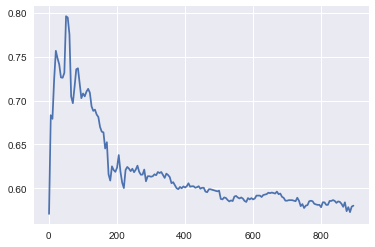

In [371]:
plt.plot(l_n,l_auc)

In [383]:
l_n =[]
l_auc =[]

for n in range(45,60,1):
    model_logistic = LogisticRegression(C=1e9)
    factors = features_df['Features'][0:n]
    model_logistic.fit(data[factors], data['Gender_1_0'])
    scores = cross_val_score(model_logistic, data[factors], data['Gender_1_0'], scoring='roc_auc')
    l_n.append(n)
    l_auc.append(scores.mean())
    
output1_logistic = pd.DataFrame.from_dict(l_n)
output2_logistic = pd.DataFrame.from_dict(l_auc)

output1_logistic.columns=['l_n']
output2_logistic.columns=['l_auc']
output_logistic = output1_logistic.join(output2_logistic)
output_logistic.sort_values(['l_auc'],ascending=False).head()

,l_n,l_auc
9,54,0.809335
10,55,0.802345
7,52,0.800523
8,53,0.797882
6,51,0.796274


#### MODEL 2: Best Logistic Regresssion Model

In [384]:
model_logistic = LogisticRegression(C=1e9)
factors = features_df['Features'][0:54]
model_logistic.fit(data[factors], data['Gender_1_0'])
scores = cross_val_score(model_logistic, data[factors], data['Gender_1_0'], scoring='roc_auc')
print('CV AUC {}, Average AUC {}'.format(scores, scores.mean()))

CV AUC [ 0.8974359   0.73578595  0.79478261], Average AUC 0.80933481977


In [385]:
pd.DataFrame(features_df['Features'][0:54])

,Features
781,|Eyeota|Interest|Food Enthusiasts|Vegetarians ...
892,|Eyeota|Seasonal|Sport Events|Football Matches...
777,|Eyeota|Interest|Food Enthusiasts|Cocktails an...
531,|Eyeota|Branded Data|Global excluding US and E...
898,segment_cnt
857,|Eyeota|Regional Taxonomies|Southeast Asia (SE...
532,|Eyeota|Branded Data|Global excluding US and E...
805,|Eyeota|Interest|Sports|Football
545,|Eyeota|Branded Data|Global excluding US and E...
584,|Eyeota|Branded Data|Global excluding US and E...


### Creating a text column with relevant Segments

In [496]:
factors = features_df['Features'][0:54]
data_54factors =  data[factors]

In [498]:
data_54factors.shape

(147, 54)

In [499]:
data_54factors = data_54factors.drop('segment_cnt', 1)

In [500]:
data_54factors.shape

(147, 53)

In [501]:
data_54factors.head()

,|Eyeota|Interest|Food Enthusiasts|Vegetarians and Vegans,|Eyeota|Seasonal|Sport Events|Football Matches|FIFA World Cup 2018,|Eyeota|Interest|Food Enthusiasts|Cocktails and Drinks,|Eyeota|Branded Data|Global excluding US and EMEA ShareThis|Food and Drink|Beverages|Coffee and Tea,|Eyeota|Regional Taxonomies|Southeast Asia (SEA)|Interest|Sports|Football,|Eyeota|Branded Data|Global excluding US and EMEA ShareThis|Food and Drink|Cooking and Recipes,|Eyeota|Interest|Sports|Football,|Eyeota|Branded Data|Global excluding US and EMEA ShareThis|Hobbies and Leisure|Special Occasions,|Eyeota|Branded Data|Global excluding US and EMEA ShareThis|Real Estate|Apartments and Residential Rentals,|Eyeota|Intent|Shopping|CPG / FMCG|Grocery,...,|Eyeota|Branded Data|Global Bombora|B2B|Install Data|Cloud Services|Platform as a Service (PaaS),|Eyeota|Regional Taxonomies|Southeast Asia (SEA)|Intent|Shopping|Grocery Buyers,|Eyeota|Intent|Shopping|Entertainment,|Eyeota|Branded Data|Global Bombora|B2C|Lifestyle|Hobbies and Interests|Concerts,|Eyeota|Intent|Shopping|Consumer Electronics|Game Console and Play Station,|Eyeota|Business or B2B|Interest|Investments and Stock Exchanges,|Eyeota|Intent|Auto Buyers,|Eyeota|Branded Data|Global Bombora|B2B|B2B Predictive Signals|Marketing|Search Marketing,|Eyeota|Branded Data|Global Bombora|B2B|B2B Predictive Signals|Technology|Hardware,|Eyeota|Demographic|Inferred Gender|Male
35,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,1,0,1,1,1,1
37,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
53,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
54,0,1,0,0,1,0,1,0,0,0,...,0,0,1,0,1,1,1,0,0,1
76,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1


In [502]:
list = data_54factors.columns

In [503]:
for n in range(0,53,1):
    factor = data_54factors.columns[n]
    d = {'1': factor, '0': ''}
    data_54factors[factor]=data_54factors[factor].apply(str)
    data_54factors[factor]=data_54factors[factor].replace(d)

In [504]:
data_54factors.head()

,|Eyeota|Interest|Food Enthusiasts|Vegetarians and Vegans,|Eyeota|Seasonal|Sport Events|Football Matches|FIFA World Cup 2018,|Eyeota|Interest|Food Enthusiasts|Cocktails and Drinks,|Eyeota|Branded Data|Global excluding US and EMEA ShareThis|Food and Drink|Beverages|Coffee and Tea,|Eyeota|Regional Taxonomies|Southeast Asia (SEA)|Interest|Sports|Football,|Eyeota|Branded Data|Global excluding US and EMEA ShareThis|Food and Drink|Cooking and Recipes,|Eyeota|Interest|Sports|Football,|Eyeota|Branded Data|Global excluding US and EMEA ShareThis|Hobbies and Leisure|Special Occasions,|Eyeota|Branded Data|Global excluding US and EMEA ShareThis|Real Estate|Apartments and Residential Rentals,|Eyeota|Intent|Shopping|CPG / FMCG|Grocery,...,|Eyeota|Branded Data|Global Bombora|B2B|Install Data|Cloud Services|Platform as a Service (PaaS),|Eyeota|Regional Taxonomies|Southeast Asia (SEA)|Intent|Shopping|Grocery Buyers,|Eyeota|Intent|Shopping|Entertainment,|Eyeota|Branded Data|Global Bombora|B2C|Lifestyle|Hobbies and Interests|Concerts,|Eyeota|Intent|Shopping|Consumer Electronics|Game Console and Play Station,|Eyeota|Business or B2B|Interest|Investments and Stock Exchanges,|Eyeota|Intent|Auto Buyers,|Eyeota|Branded Data|Global Bombora|B2B|B2B Predictive Signals|Marketing|Search Marketing,|Eyeota|Branded Data|Global Bombora|B2B|B2B Predictive Signals|Technology|Hardware,|Eyeota|Demographic|Inferred Gender|Male
35,,,,,,|Eyeota|Branded Data|Global excluding US and E...,,,,,...,,,,|Eyeota|Branded Data|Global Bombora|B2C|Lifest...,|Eyeota|Intent|Shopping|Consumer Electronics|G...,,|Eyeota|Intent|Auto Buyers,|Eyeota|Branded Data|Global Bombora|B2B|B2B Pr...,|Eyeota|Branded Data|Global Bombora|B2B|B2B Pr...,|Eyeota|Demographic|Inferred Gender|Male
37,,,,,,,,,,,...,,,,,,,,|Eyeota|Branded Data|Global Bombora|B2B|B2B Pr...,,
53,,,,,,,,,,,...,,,|Eyeota|Intent|Shopping|Entertainment,,|Eyeota|Intent|Shopping|Consumer Electronics|G...,,,,,
54,,|Eyeota|Seasonal|Sport Events|Football Matches...,,,|Eyeota|Regional Taxonomies|Southeast Asia (SE...,,|Eyeota|Interest|Sports|Football,,,,...,,,|Eyeota|Intent|Shopping|Entertainment,,|Eyeota|Intent|Shopping|Consumer Electronics|G...,|Eyeota|Business or B2B|Interest|Investments a...,|Eyeota|Intent|Auto Buyers,,,|Eyeota|Demographic|Inferred Gender|Male
76,,,,,,,,,,,...,,,,,,,|Eyeota|Intent|Auto Buyers,,,|Eyeota|Demographic|Inferred Gender|Male


In [669]:
data_54factors['segment_text'] = data_54factors[list].apply(lambda x: ''.join(x), axis=1)

In [670]:
data_54factors['segment_text'] = data_54factors['segment_text'].str.replace('|', ' ')


In [671]:
data_54factors.shape

(147, 54)

### Logistic Regression using Vectorizer

In [692]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score


my_additional_stop_words = ['Eyeota']
stop_words = text.ENGLISH_STOP_WORDS.union(my_additional_stop_words)
vectorizer = CountVectorizer(max_features = 1000, 
                             ngram_range=(1, 2), 
                             stop_words='english',
                             binary=False)
vectorizer.fit(data_54factors['segment_text'])
X = vectorizer.transform(data_54factors['segment_text'])

#### MODEL 3: Logistic Regression with Vectorizer

In [713]:
lv_feature = []
lv_ngram = []
lv_auc = []


for  i in range(100,2000,200):
    for j in range(1,3,1):
        vectorizer = CountVectorizer(max_features = i, 
                                 ngram_range=(1, j), 
                                 stop_words='english',
                                 binary=False)
        vectorizer.fit(data_54factors['segment_text'])
        X = vectorizer.transform(data_54factors['segment_text'])
        model = LogisticRegression(penalty = 'l1')
        y = data['Gender_1_0']
        scores = cross_val_score(model, X, y, scoring='roc_auc')
        lv_feature.append(i)
        lv_ngram.append(j)
        lv_auc.append(scores.mean())
        
output1_logisticv = pd.DataFrame.from_dict(lv_feature)
output2_logisticv = pd.DataFrame.from_dict(lv_ngram)
output3_logisticv = pd.DataFrame.from_dict(lv_auc)

output1_logisticv.columns=['lv_feature']
output2_logisticv.columns=['lv_ngram']
output3_logisticv.columns=['lv_auc']
output_logisticv = output1_logisticv.join(output2_logisticv).join(output3_logisticv)
output_logisticv.sort_values(['lv_auc'],ascending=False).head()

,lv_feature,lv_ngram,lv_auc
3,300,2,0.764054
15,1500,2,0.761870
11,1100,2,0.761870
13,1300,2,0.761825
7,700,2,0.761825


### Logistic Regression Using Segments and Vectorizer

In [714]:
from scipy.sparse import hstack

In [697]:
model_logistic_v = LogisticRegression(C=1e9)
data_new = hstack((X,data_54factors.drop('segment_text', 1).shape))
factors = data_new
model_logistic_v.fit(data_new, data['Gender_1_0'])
scores = cross_val_score(model_logistic_v, data_new, data['Gender_1_0'], scoring='roc_auc')
print('CV AUC {}, Average AUC {}'.format(scores, scores.mean()))

CV AUC [ 0.79326923  0.76839465  0.78695652], Average AUC 0.782873467113


In [ ]:
lv2_feature = []
lv2_ngram = []
lv2_auc = []


for  i in range(100,2000,200):
    for j in range(1,3,1):
        vectorizer = CountVectorizer(max_features = i, 
                                 ngram_range=(1, j), 
                                 stop_words='english',
                                 binary=False)
        vectorizer.fit(data_54factors['segment_text'])
        X = data_new
        model = LogisticRegression(penalty = 'l1')
        y = data['Gender_1_0']
        scores = cross_val_score(model, X, y, scoring='roc_auc')
        lv2_feature.append(i)
        lv2_ngram.append(j)
        lv2_auc.append(scores.mean())
        
output1_logisticv2 = pd.DataFrame.from_dict(lv2_feature)
output2_logisticv2 = pd.DataFrame.from_dict(lv2_ngram)
output3_logisticv2 = pd.DataFrame.from_dict(lv2_auc)

output1_logisticv.columns=['lv2_feature']
output2_logisticv.columns=['lv2_ngram']
output3_logisticv.columns=['lv2_auc']
output_logisticv = output1_logisticv2.join(output2_logisticv2).join(output3_logisticv2)
output_logisticv.sort_values(['lv2_auc'],ascending=False).head()

In [699]:
coef=pd.DataFrame(model_logistic_v.coef_).transpose()

In [700]:
feature_s = pd.DataFrame(data_54factors.drop('segment_text', 1).columns)

In [701]:
feature_v = pd.DataFrame(vectorizer.get_feature_names())

In [702]:
feature = []
feature = feature_s.append(feature_v).reset_index()

In [703]:
model_features_coeff = pd.concat([feature, coef], axis=1, join_axes=[feature.index]).reset_index()

In [704]:
model_features_coeff.columns=['0','0','feature','coef']

In [705]:
model_features_coeff = model_features_coeff[['feature','coef']]

In [706]:
model_features_coeff.sort_values('coef').head(10)

,feature,coef
237,home,-40.844877
64,advocacy,-28.023348
91,beauty beauty,-17.844702
224,halloween,-16.030902
272,lifestyle outdoor,-16.030902
273,male,-16.030902
330,seasonal sport,-11.049251
207,game console,-11.049251
208,garden,-11.049251
331,service,-11.049251


In [707]:
model_features_coeff.sort_values('coef').tail(10)

,feature,coef
303,professional groups,13.082163
174,excluding,14.794107
230,hobbies,16.372465
133,demand generation,16.858264
296,platform service,17.530329
135,demographic inferred,17.530329
51,|Eyeota|Branded Data|Global Bombora|B2B|B2B Pr...,21.784888
326,search marketing,31.017587
337,sharethis arts,35.740055
239,home owners,40.763688
